## NYCBusTimePrediction Exploratory Analysis

#### Variable Names
1.latitude
2.longitude
3.time_received
4.vehicle_id
5.distance_along_trip
6.inferred_direction_id
7.inferred_phase
8.inferred_route_id
9.inferred_trip_id
10.next_scheduled_stop_distance
11.next_scheduled_stop_id

Source: http://web.mta.info/developers/resources/nyct/MTA-Bus-Time-fields.htm

In [1]:
# Loading required libraries
%matplotlib inline
import csv
import pandas as pd
import glob
import pandas as pd
import matplotlib as matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## For M10 Bus Line

In [2]:
# Getting filenames from the current working directory
filenames = glob.glob('./*.txt')

# Getting all the rows for a given busline
lines = []

def mtabusdata(filename, busline):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi, delimiter='\t', quoting=csv.QUOTE_NONE)
        for row in reader:
            if row['inferred_route_id'].rsplit("_",1)[-1] == busline:
                yield row

for i in filenames:
    print i
    g = mtabusdata(i, 'M10')
    for i in g:
        lines.append(i)
    print len(lines)

.\MTA-Bus-Time_.2014-08-01.txt
21939


In [3]:
# Converting the list of dictionaries into a pandas dataframe
data_M10 = pd.DataFrame(lines)
print data_M10.shape

(21939, 11)


In [4]:
# Converting data types of few features
data_M10['distance_along_trip'] = data_M10['distance_along_trip'].astype(float)
data_M10['next_scheduled_stop_distance'] = data_M10['next_scheduled_stop_distance'].astype(float)
data_M10['time_received'] = pd.to_datetime(data_M10['time_received'])

# Splitting datetime into date and time features
tempDatetime = pd.DatetimeIndex(data_M10['time_received'])
data_M10['date'] = pd.to_datetime(tempDatetime.date)
data_M10['time'] = pd.to_datetime(tempDatetime.time)

# Extracting hour and minute from the datetime variable
data_M10['hour'] = pd.DatetimeIndex(data_M10['time_received']).hour
data_M10['minute'] = pd.DatetimeIndex(data_M10['time_received']).minute

In [5]:
data_M10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21939 entries, 0 to 21938
Data columns (total 15 columns):
distance_along_trip             21939 non-null float64
inferred_direction_id           21939 non-null object
inferred_phase                  21939 non-null object
inferred_route_id               21939 non-null object
inferred_trip_id                21939 non-null object
latitude                        21939 non-null object
longitude                       21939 non-null object
next_scheduled_stop_distance    21939 non-null float64
next_scheduled_stop_id          21939 non-null object
time_received                   21939 non-null datetime64[ns]
vehicle_id                      21939 non-null object
date                            21939 non-null datetime64[ns]
time                            21939 non-null object
hour                            21939 non-null int32
minute                          21939 non-null int32
dtypes: datetime64[ns](2), float64(2), int32(2), object(9)
memory

### Performing Exploratory Analysis

In [6]:
# Computing descriptive statistics for numeric variables
data_M10.describe()

,distance_along_trip,next_scheduled_stop_distance,hour,minute
count,21939.000000,21939.000000,21939.000000,21939.000000
mean,4115.117847,96.955647,14.145358,29.431059
std,2761.727127,83.574799,6.644728,17.366975
min,0.000000,0.000000,0.000000,0.000000
25%,1662.849163,18.168975,11.000000,14.000000
50%,4069.735689,73.046656,15.000000,29.000000
75%,6462.263015,157.817242,20.000000,45.000000
max,9479.438734,330.384682,23.000000,59.000000


>__Following observations can be made from the above summary statistics output:__

>__1.distance_along_trip:__ given in metres, ranging from 0 to ~9500 values with a median of ~4070.<br>
>__2.next_scheduled_stop_distance:__ given in metres, from 0 to ~330 implying maximum distance between two stops on this line as 330 metres, and on an average stops are at a distance of ~100 metres. <br>
>__3.hour:__ it varies between 0 and 23 implying a 24 hour clock 

In [7]:
# Computing descriptive statistics for categorical variables
data_M10.select_dtypes(include=['object']).describe()

,inferred_direction_id,inferred_phase,inferred_route_id,inferred_trip_id,latitude,longitude,next_scheduled_stop_id,vehicle_id,time
count,21939,21939,21939,21939,21939,21939,21939,21939,21939
unique,2,3,1,197,14595,13979,90,24,18893
top,1,IN_PROGRESS,MTA NYCT_M10,MTA NYCT_MV_C4-Weekday-066900_M10_815,40.804265,-73.955644,MTA_401305,6705,21:11:00
freq,12078,19360,21939,291,88,94,1675,1897,5


>__Following observations can be made from the above summary statistics output:__

>__1.inferred_direction_id:__ takes 2 values 0 and 1 which implies travel in one and opposite directions respectively.<br>
>__2.inferred_phase:__ takes 3 values, IN PROGRESS (i.e. driving) or LAYOVER DURING/LAYOVER BEFORE (i.e. waiting at terminal). <br>
>__3.vehicle_id:__ 3 or 4 digit bus number, takes 24 unique values which means different vehicles serving the same line. 

In [8]:
# Looking at frequency of vehicle ids
data_M10.groupby(['vehicle_id']).size().order(ascending=False)[:5]

vehicle_id
6705    1897
6706    1808
6646    1807
6678    1755
6649    1609
dtype: int64

### Looking at the time based plots for the top 3 high frequent vehicle types

#### Checking for inconsistencies during IN_PROGRESS phase

In [9]:
def bustimeplotINProgress(busNum):
    data = data_M10.loc[data_M10['inferred_phase'] == 'IN_PROGRESS', :]
    data = data.loc[data['vehicle_id'] == busNum, :]
    print data['hour'].unique()
    mean_trip_dist = data.groupby(['hour','minute','inferred_direction_id'])['distance_along_trip'].mean()
    plt.figure(figsize=(12, 10))
    mean_trip_dist.plot()

[11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]


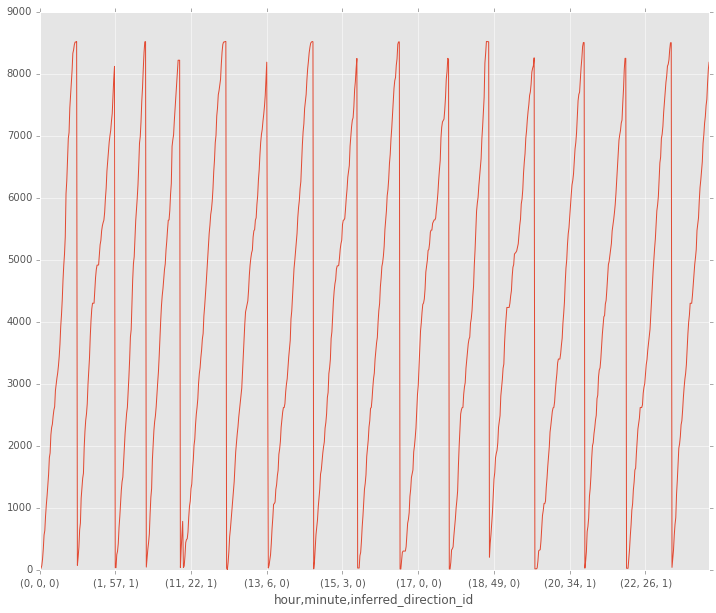

In [10]:
# For vehicle id 6705
bustimeplotINProgress('6705')

[11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]


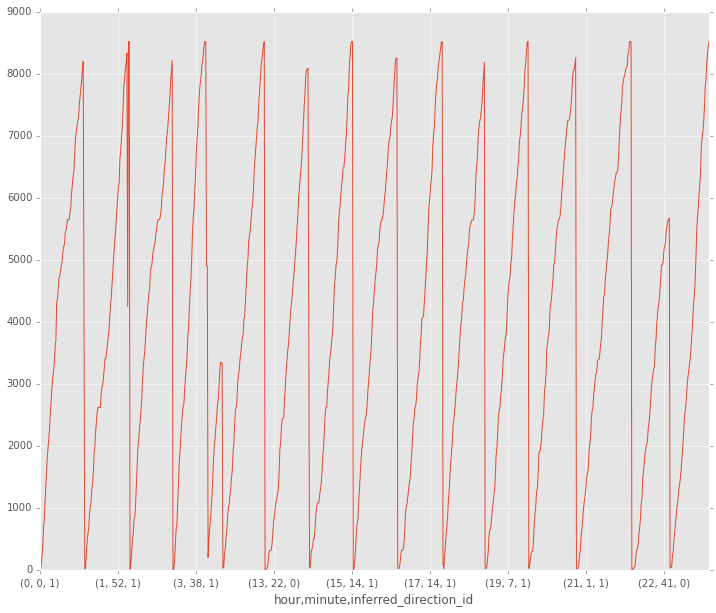

In [11]:
# For vehicle id 6706
bustimeplotINProgress('6706')

[11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]


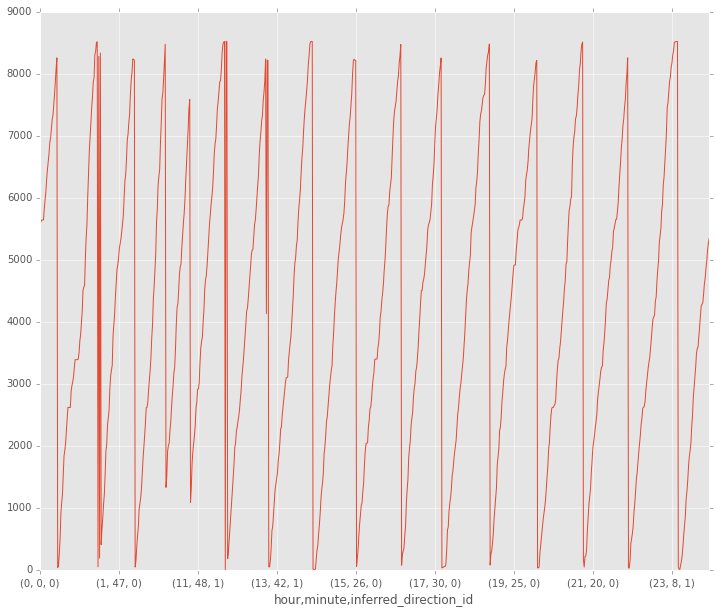

In [12]:
# For vehicle id 6646
bustimeplotINProgress('6646')

#### Checking for inconsistencies during LAYOVER phase

In [13]:
def bustimeplotLAYOVER(busNum):
    data = data_M10.loc[data_M10['inferred_phase'] != 'IN_PROGRESS', :]
    data = data.loc[data['vehicle_id'] == busNum, :]
    print data['hour'].unique()
    mean_trip_dist = data.groupby(['hour','minute','inferred_direction_id'])['distance_along_trip'].mean()
    plt.figure(figsize=(12, 10))
    mean_trip_dist.plot()

[12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]


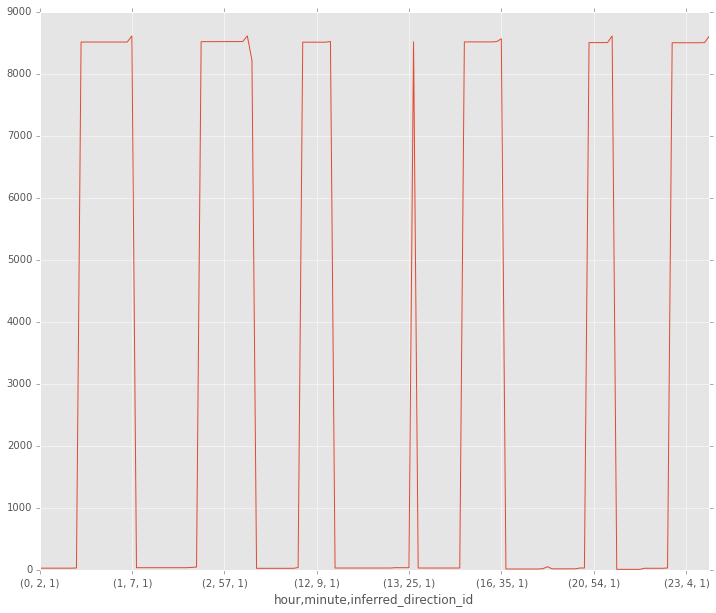

In [14]:
# For vehicle id 6705
bustimeplotLAYOVER('6705')

[12 13 14 15 16 17 18 19 20 21 22 23  0  1  3]


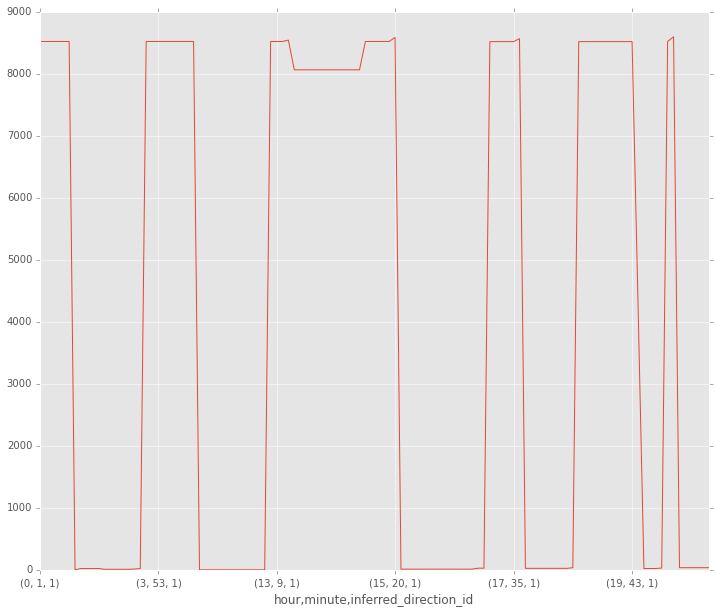

In [15]:
# For vehicle id 6706
bustimeplotLAYOVER('6706')

[12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]


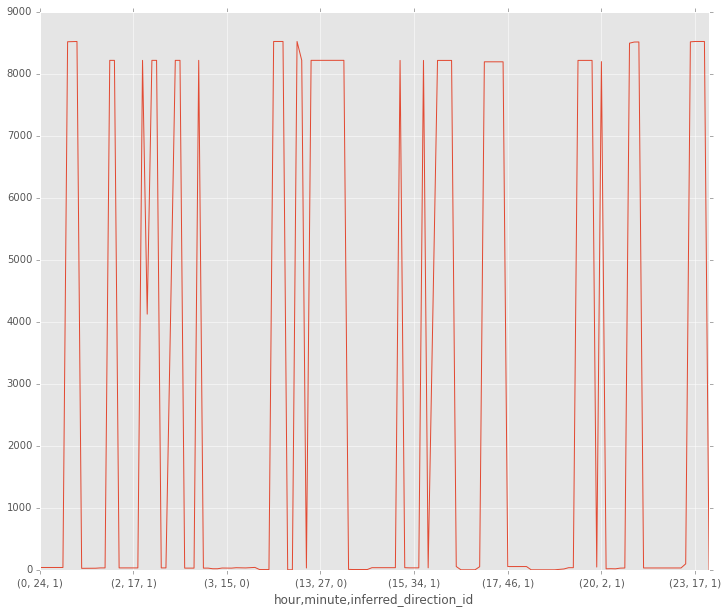

In [16]:
# For vehicle id 6646
bustimeplotLAYOVER('6646')

## For M15 Bus Line

In [17]:
# Getting filenames from the current working directory
filenames = glob.glob('./*.txt')

# Getting all the rows for a given busline
lines = []

def mtabusdata(filename, busline):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi, delimiter='\t', quoting=csv.QUOTE_NONE)
        for row in reader:
            if row['inferred_route_id'].rsplit("_",1)[-1] == busline:
                yield row

for i in filenames:
    print i
    g = mtabusdata(i, 'M15')
    for i in g:
        lines.append(i)
    print len(lines)

.\MTA-Bus-Time_.2014-08-01.txt
41297


In [18]:
# Converting the list of dictionaries into a pandas dataframe
data_M15 = pd.DataFrame(lines)
print data_M15.shape

(41297, 11)


In [19]:
# Converting data types of few features
data_M15['distance_along_trip'] = data_M15['distance_along_trip'].astype(float)
data_M15['next_scheduled_stop_distance'] = data_M15['next_scheduled_stop_distance'].astype(float)
data_M15['time_received'] = pd.to_datetime(data_M15['time_received'])

# Splitting datetime into date and time features
tempDatetime = pd.DatetimeIndex(data_M15['time_received'])
data_M15['date'] = pd.to_datetime(tempDatetime.date)
data_M15['time'] = pd.to_datetime(tempDatetime.time)

# Extracting hour and minute from the datetime variable
data_M15['hour'] = pd.DatetimeIndex(data_M15['time_received']).hour
data_M15['minute'] = pd.DatetimeIndex(data_M15['time_received']).minute

In [20]:
data_M15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41297 entries, 0 to 41296
Data columns (total 15 columns):
distance_along_trip             41297 non-null float64
inferred_direction_id           41297 non-null object
inferred_phase                  41297 non-null object
inferred_route_id               41297 non-null object
inferred_trip_id                41297 non-null object
latitude                        41297 non-null object
longitude                       41297 non-null object
next_scheduled_stop_distance    41297 non-null float64
next_scheduled_stop_id          41297 non-null object
time_received                   41297 non-null datetime64[ns]
vehicle_id                      41297 non-null object
date                            41297 non-null datetime64[ns]
time                            41297 non-null object
hour                            41297 non-null int32
minute                          41297 non-null int32
dtypes: datetime64[ns](2), float64(2), int32(2), object(9)
memory

In [21]:
# Looking at frequency of vehicle ids
data_M15.groupby(['vehicle_id']).size().order(ascending=False)[:5]

vehicle_id
5624    2448
5644    2353
5620    2178
5633    2161
5522    2119
dtype: int64

#### Checking for inconsistencies on IN_PROGRESS phase

In [22]:
def bustimeplotINProgress(busNum):
    data = data_M15.loc[data_M15['inferred_phase'] == 'IN_PROGRESS', :]
    data = data.loc[data['vehicle_id'] == busNum, :]
    print data['hour'].unique()
    mean_trip_dist = data.groupby(['hour','minute','inferred_direction_id'])['distance_along_trip'].mean()
    plt.figure(figsize=(12, 10))
    mean_trip_dist.plot()

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]


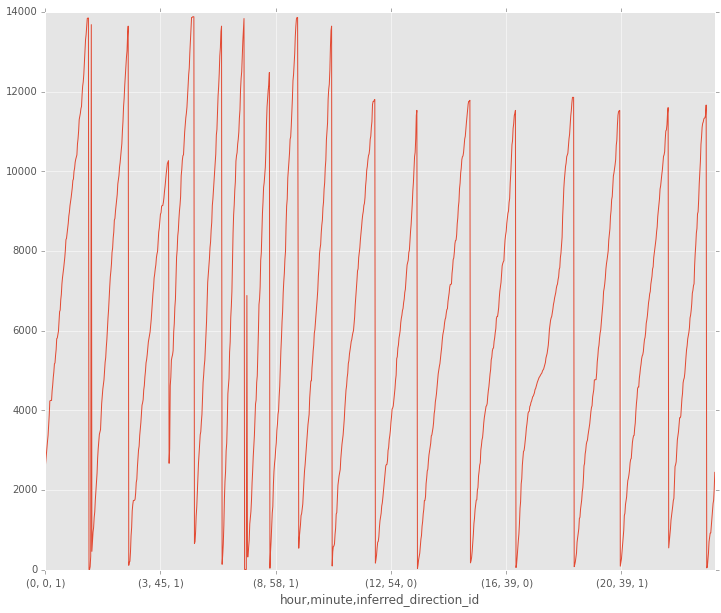

In [23]:
# For vehicle id 5624
bustimeplotINProgress('5624')

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]


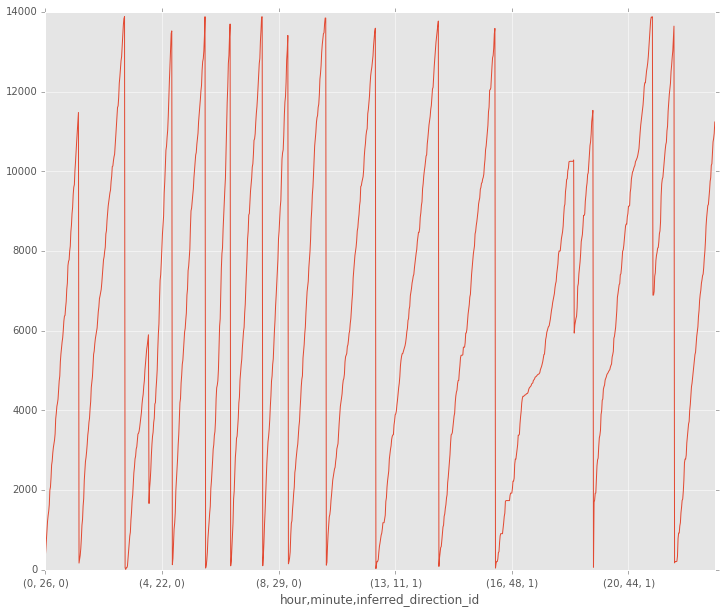

In [24]:
# For vehicle id 5644
bustimeplotINProgress('5644')

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]


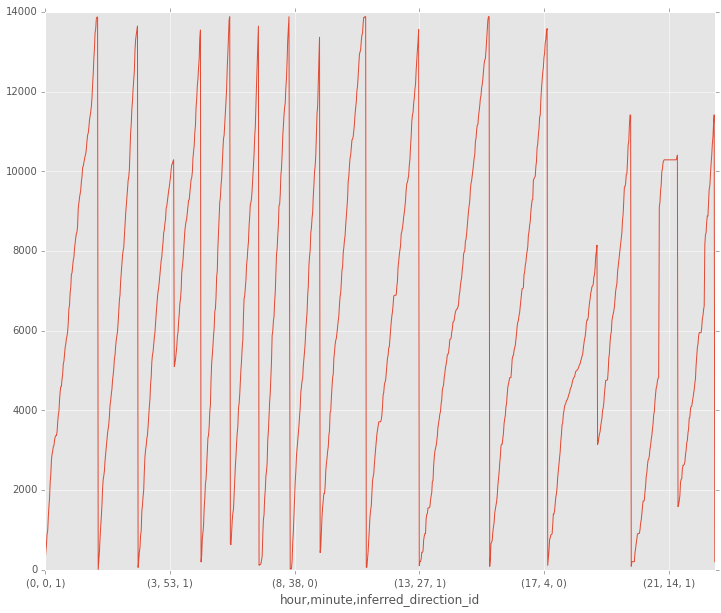

In [25]:
# For vehicle id 5620
bustimeplotINProgress('5620')

#### Checking for inconsistencies on LAYOVER phase

In [26]:
def bustimeplotLAYOVER(busNum):
    data = data_M15.loc[data_M15['inferred_phase'] != 'IN_PROGRESS', :]
    data = data.loc[data['vehicle_id'] == busNum, :]
    print data['hour'].unique()
    mean_trip_dist = data.groupby(['hour','minute','inferred_direction_id'])['distance_along_trip'].mean()
    plt.figure(figsize=(12, 10))
    mean_trip_dist.plot()

[ 4  5  6  7  8  9 12 15 18 19 22 23  1]


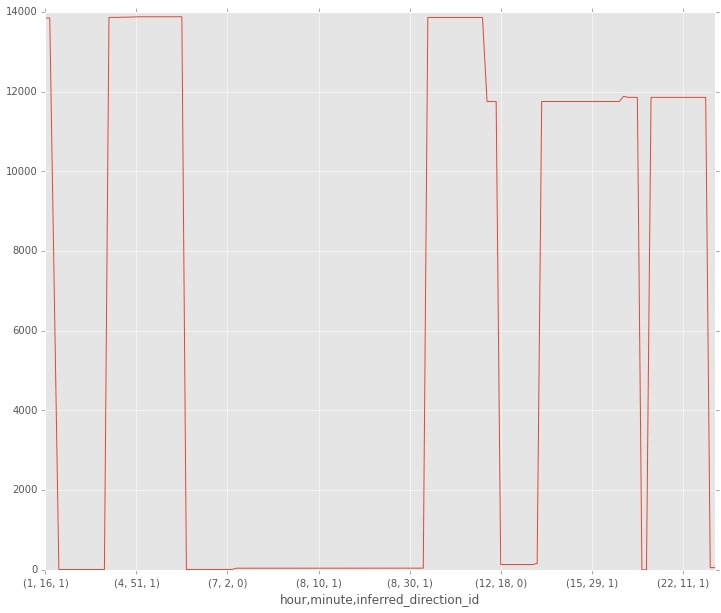

In [27]:
# For vehicle id 5624
bustimeplotLAYOVER('5624')

[ 4  5  6  7  8  9 10 11 14 21  0  3]


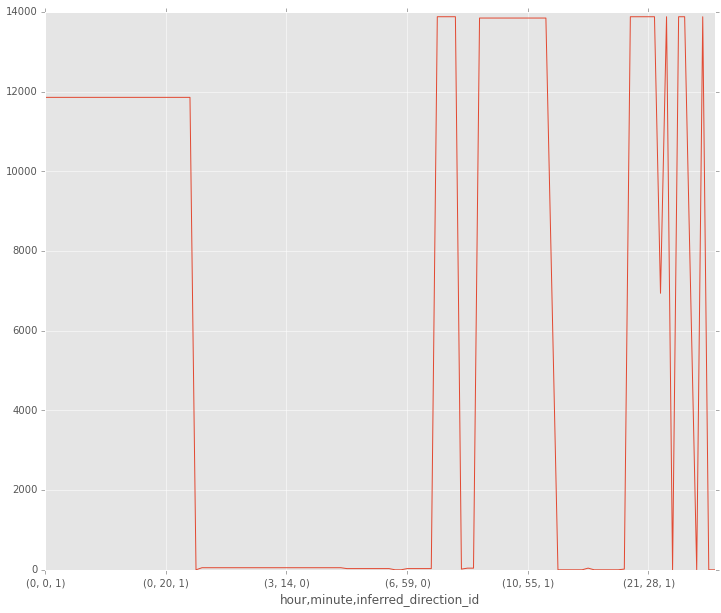

In [28]:
# For vehicle id 5634
bustimeplotLAYOVER('5644')

[ 5  7  8 10 11 15  1]


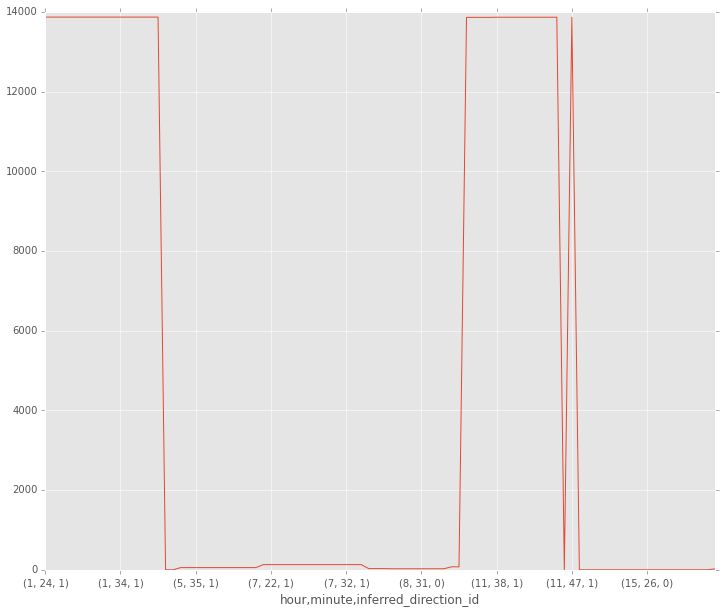

In [29]:
# For vehicle id 5620
bustimeplotLAYOVER('5620')